# Vanilla Online Q Learning

## Features
* Discrete action space
* Input: length of state space
* Ouput: length of action space

## Test env
* InvertedPendulumMuJoCoEnv-v0 **[Solved]**
* HalfCheetahMuJoCoEnv-v0 **[Solved]**
* Breakout-ram-v4 **[Better than random]**


In [1]:
# load gym envs and common functions
from utils import *

In [2]:
# Vanilla Q learner
# Discrete action space and 1D state vector
class VanillaQ:
    def __init__(self, net, opt, actions, device, gamma=0.99):
        self.name = "VanillaQ"
        self.policy = net
        self.opt = opt
        self.gamma = gamma
        self.actions = actions
        self.device = device
        
    def load(self, data):
        self.policy.load_state_dict(data['policy'])
        
    def save(self):
        return {'policy': self.policy.state_dict()}
    
    def prep(self, s):
        return torch.from_numpy(s).float().view(1, -1).to(self.device)
    
    def forward(self, s):
        with torch.no_grad():
            return self.policy(self.prep(s)).max(1)[1][0]

    def e_greedy(self, s, epsilon):
        action_len = len(self.actions)
        p = np.ones(action_len) * epsilon / action_len
        p[self.forward(s)] += 1 - epsilon
        return np.random.choice(action_len, p=p)
        
    def best(self, s):
        return self.actions[self.forward(s)]
        
    def train(self, s, a, r, sp, done):
        s = self.prep(s) # 1 * n
        sp = self.prep(sp) # 1 * n
        r = torch.Tensor([r]).view(-1, 1).to(self.device)
        a = torch.Tensor([a]).long().view(-1, 1).to(self.device)
        
        if done:
            target_q = r
        else:
            with torch.no_grad():
                next_q = self.policy(sp).max(1)[0]
            target_q = r + self.gamma * next_q

        current_q = self.policy(s).gather(1, a)
        loss = F.mse_loss(current_q, target_q)
        
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


def vanilla_q_learning(env_name, agent, config, seed=0):
    set_seeds(seed)
    
    # init env
    env = gym.make(env_name)
    print("Env:", env_name)
    print("Action space:", env.action_space)
    print("Obs space:", env.observation_space)
    print("Agent:", agent.name)
    
    epoch, rewards, max_reward = load_state(env_name, agent)
    print(f"Start at epoch {epoch}, max_reward: {max_reward}")
    
    # start training and test
    while epoch < config.get('max_epoch', 5000):
        try:
            loss = 0
            # learning
            obs = env.reset()
            train_step = 0
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.e_greedy(s, config.get('epsilon', 0.1))
                # One step
                obs, r, done, _ = env.step(agent.actions[a])
                loss += agent.train(s, a, r, obs.ravel(), done)
                if done:
                    loss /= (i + 1)
                    break
            
            # test
            test_reward = 0
            obs = env.reset()
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.best(s)
                obs, r, done, _ = env.step(a)
                test_reward += r
                if done:
                    break
            
            # save reward
            rewards.append(test_reward)
            print(f"Epoch {epoch} | Avg loss: {loss} | Test reward: {test_reward:.1f}")
            
            # save states
            if test_reward >= max_reward or epoch % config.get('save_interval', 100) == 0:
                max_reward = max(test_reward, max_reward)
                save_state(env_name, agent, f'-{epoch}', epoch, rewards)
            epoch += 1
        except KeyboardInterrupt:
            break
        except:
            traceback.print_exc()
            break
    save_state(env_name, agent, '', epoch, rewards)
    # clean up
    env.close()
    # plot rewards
    draw_training_rewards(f"{agent.name} - {env_name}", rewards, config['plt_smooth'])

###  Env 1 InvertedPendulumMuJoCoEnv-v0

In [3]:
# Initialize network, optimizer and agent

config = {
    "save_interval": 500,
    "max_epoch": 2000,
    "max_step": 1000,
    "epsilon": 0.1, # e-greedy
    "gamma": 0.9,   # discount factor
    "lr": 0.001,    # learning rate
    "plt_smooth": 1,    #
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 3-layer FC network
from model.FCN3 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[-1], [0], [1]]
net = FCN3(4, len(actions), 32).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = VanillaQ(net, opt, actions, device, gamma=config['gamma'])

In [ ]:
# train agent
vanilla_q_learning("InvertedPendulumMuJoCoEnv-v0", agent, config)

current_dir=/home/xine/.local/lib/python3.6/site-packages/pybullet_envs/bullet
options= 
Test VanillaQ at epoch 1862, max_reward: 1000.0
options= 
Test 1 | Step: 1000 | Test reward: 1000.0
Test 2 | Step: 1000 | Test reward: 1000.0
Test 3 | Step: 1000 | Test reward: 1000.0
Test 4 | Step: 1000 | Test reward: 1000.0
Test 5 | Step: 1000 | Test reward: 1000.0
Test 6 | Step: 1000 | Test reward: 1000.0
Test 7 | Step: 1000 | Test reward: 1000.0
Test 8 | Step: 1000 | Test reward: 1000.0
Test 9 | Step: 1000 | Test reward: 1000.0
Test 10 | Step: 1000 | Test reward: 1000.0
Mean reward: 1000.0.


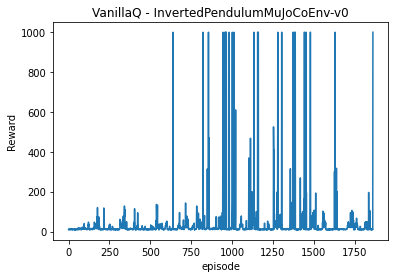

In [4]:
# evaluate agent
evaluate_agent("InvertedPendulumMuJoCoEnv-v0", agent, config)

###  Env 2 HalfCheetahMuJoCoEnv-v0

In [5]:
config = {
    "save_interval": 500,
    "max_epoch": 50000,
    "max_step": 200,
    "epsilon": 0.1, # e-greedy
    "gamma": 0.9,   # discount factor
    "lr": 0.0001,    # learning rate
    "plt_smooth": 11,    #
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[j1, j2, j3, j4, j5, j6] for j1 in range(-1, 2)
           for j2 in range(-1, 2)
           for j3 in range(-1, 2)
           for j4 in range(-1, 2)
           for j5 in range(-1, 2)
           for j6 in range(-1, 2)]
net = FCN5(17, len(actions), 256).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = VanillaQ(net, opt, actions, device, gamma=config['gamma'])

In [ ]:
# train agent
vanilla_q_learning("HalfCheetahMuJoCoEnv-v0", agent, config)

WalkerBase::__init__
options= 
Test VanillaQ at epoch 37916, max_reward: 155.14566803874226
options= 
Test 1 | Step: 1000 | Test reward: 608.9
Test 2 | Step: 1000 | Test reward: 529.0
Test 3 | Step: 1000 | Test reward: 143.1
Test 4 | Step: 1000 | Test reward: 645.7
Test 5 | Step: 1000 | Test reward: 38.0
Test 6 | Step: 1000 | Test reward: 695.6
Test 7 | Step: 1000 | Test reward: 89.8
Test 8 | Step: 1000 | Test reward: 400.8
Test 9 | Step: 1000 | Test reward: 665.7
Test 10 | Step: 1000 | Test reward: 651.3
Mean reward: 446.8.


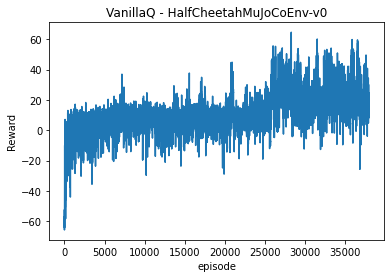

In [6]:
# evaluate agent
evaluate_agent("HalfCheetahMuJoCoEnv-v0", agent, config)

###  Env 3 Breakout-ram-v4

In [7]:
# Initialize network, optimizer and agent

config = {
    "save_interval": 500,
    "max_epoch": 100000,
    "max_step": 1000,
    "epsilon": 0.1, # e-greedy
    "gamma": 0.9,   # discount factor
    "lr": 0.001,    # learning rate
    "plt_smooth": 1,    #
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[0], [1], [2], [3]]
net = FCN5(128, len(actions), 128).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = VanillaQ(net, opt, actions, device, gamma=config['gamma'])

def normalized_prep(self, s):
    val = torch.from_numpy(s).float() / 255
    return val.view(1, -1).to(self.device)

import types
agent.prep=types.MethodType(normalized_prep, agent)
        

In [ ]:
# train agent
vanilla_q_learning("Breakout-ram-v4", agent, config)

Test VanillaQ at epoch 81989, max_reward: 12.0
Test 1 | Step: 277 | Test reward: 3.0
Test 2 | Step: 283 | Test reward: 3.0
Test 3 | Step: 288 | Test reward: 3.0
Test 4 | Step: 653 | Test reward: 12.0
Test 5 | Step: 285 | Test reward: 3.0
Test 6 | Step: 283 | Test reward: 3.0
Test 7 | Step: 664 | Test reward: 12.0
Test 8 | Step: 290 | Test reward: 3.0
Test 9 | Step: 655 | Test reward: 12.0
Test 10 | Step: 282 | Test reward: 3.0
Mean reward: 5.7.


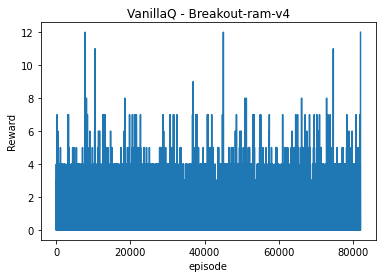

In [8]:
# evaluate agent
evaluate_agent("Breakout-ram-v4", agent, config)